# Load packages

In [1]:
import streamlit 
import platform
import string
from deepmultilingualpunctuation import PunctuationModel
import tqdm
from colorama import Fore, Style
from transformers import pipeline, __version__ as transformers_version
import matplotlib  # note: import matplotlib, not pyplot
import matplotlib.pyplot as plt
from collections import Counter
import re
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import text as mp_text
import torch
import cv2

/home/alae/anaconda3/envs/media/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Collect versions
package_versions = {
    "Python": platform.python_version(),
    "string": "built-in",
    "deepmultilingualpunctuation": PunctuationModel.__module__.split('.')[0],
    "tqdm": tqdm.__version__,
    "streamlit": streamlit.__version__,
    "colorama": Fore.__module__.split('.')[0],
    "transformers": transformers_version,
    "matplotlib": matplotlib.__version__,  # correct
    "collections": "built-in",
    "re": "built-in",
    "mediapipe": mp.__version__,
    "torch": torch.__version__,
    "opencv": cv2.__version__}

# Print nicely
print("Packages and Versions:")
for pkg, ver in package_versions.items():
    print(f"{pkg}: {ver}")

Packages and Versions:
Python: 3.9.25
string: built-in
deepmultilingualpunctuation: deepmultilingualpunctuation
tqdm: 4.67.1
streamlit: 1.50.0
colorama: colorama
transformers: 4.57.6
matplotlib: 3.9.4
collections: built-in
re: built-in
mediapipe: 0.10.21
torch: 2.8.0+cu128
opencv: 4.11.0


# detect language

In [3]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import text as mp_text

model_path = 'det_lang_mod/language_detector.tflite'
base_options = python.BaseOptions(model_asset_path=model_path)
options = mp_text.LanguageDetectorOptions(base_options=base_options)

In [4]:
path = "text.txt"

with open(path, "r", encoding="utf-8") as f:
    text_input = f.read()
with mp_text.LanguageDetector.create_from_options(options) as detector:
    detection_result = detector.detect(text_input)
detection = detection_result.detections[0]
language = detection.language_code

if language == 'en':
    lang = 'English'
elif language == 'fr':
    lang = 'Français'
else:
    lang = f"Unknown Language {language}"

confidence = detection.probability
print(f"Language: {lang} (Confidence: {confidence:.2f})")

Language: English (Confidence: 1.00)


I0000 00:00:1770140984.051285  177771 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1770140984.054000  177884 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.3), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 17.0.6, DRM 3.57, 6.8.0-90-generic)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1770140984.056983  177886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# remove and restore ponctuation

In [5]:
import string
from deepmultilingualpunctuation import PunctuationModel
import tqdm as tqdm

In [8]:
# Initialize the punctuation model
punct_model = PunctuationModel()
def remove_punctuation(text):
    """Removes all punctuation from the text."""
    return text.translate(str.maketrans('', '', string.punctuation))

def restore_punctuation(paragraph):
    """Removes existing punctuation and applies the model to restore it."""
    # Step 1: remove current punctuation
    text_no_punct = remove_punctuation(paragraph)
    # Step 2: restore punctuation using model
    punctuated_text = punct_model.restore_punctuation(text_no_punct)
    return punctuated_text

Device set to use cpu


In [9]:
# Example usage
raw_paragraph = """i worked at google, for five years i learned a lot about. teamwork and leadership i managed, a small team of interns"""
print("Original:", raw_paragraph)
print("----------------------------------")
parag = remove_punctuation(raw_paragraph)
print("no ponct:", parag)
print("----------------------------------")
punctuated_paragraph = restore_punctuation(raw_paragraph)
print("\nPunctuated:", punctuated_paragraph)

Original: i worked at google, for five years i learned a lot about. teamwork and leadership i managed, a small team of interns
----------------------------------
no ponct: i worked at google for five years i learned a lot about teamwork and leadership i managed a small team of interns
----------------------------------

Punctuated: i worked at google for five years. i learned a lot about teamwork and leadership. i managed a small team of interns.


In [10]:
print("----------------------------------")
text_fr = "je travaille chez google depuis cinq ans j'ai beaucoup appris sur le travail en équipe"
punctuated = punct_model.restore_punctuation(text_fr)
print(punctuated)

----------------------------------
je travaille chez google depuis cinq ans. j'ai beaucoup appris sur le travail en équipe.


# Split text into sentences

In [11]:
import re
def split_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return [s.strip() for s in sentences if s.strip()]

In [12]:
parag = restore_punctuation(text_input)
split_sentences(parag)

['Politics can inspire hope and give people the desire to improve society.',
 'It can also create anger and a strong feeling of injustice.',
 'Some speeches bring confidence and a positive vision of the future.',
 'Other decisions generate fear and deep collective frustration.',
 'There are moments of solidarity and shared pride, Yet there is also deception and lasting moral exhaustion.',
 'Politics can unite people around common values.',
 'It can just as easily divide and hurt communities.',
 'Sometimes it opens the door to progress and dignity.',
 'Often it leaves a bitter feeling, but also a small hope for renewal.']

# Sentiment

## download, or load the sentiment model if it's already downloaded

In [36]:
from colorama import Fore, Style
from transformers import pipeline
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment")
#sentiment_model = pipeline(
#    "sentiment-analysis",model="clapAI/mmBERT-small-multilingual-sentiment")

Device set to use cpu


In [37]:
def analyze_sentiment(text):
    result = sentiment_model(text)[0]
    label = result["label"]
    # Map only if necessary
    if label.startswith("LABEL_"):
        LABEL_MAP = {
            "LABEL_0": "negative",
            "LABEL_1": "neutral",
            "LABEL_2": "positive"}
        sentiment = LABEL_MAP[label]
    else:
        sentiment = label.lower()  # already 'positive', 'neutral', 'negative'
    confidence = result["score"]
    return sentiment, confidence
    
def color_text(text, sentiment):
    colors = {"positive": "\033[94m", "neutral": "\033[92m", "negative": "\033[91m"}
    reset = "\033[0m"
    print(f"{colors[sentiment]}{text}{reset}")

# predictions

In [38]:
sentences = split_sentences(parag)
for s in sentences:
    sentiment, confidence = analyze_sentiment(s)
    output = f"{s} → {sentiment} ({confidence:.2f})"
    color_text(output, sentiment)

Politics can inspire hope and give people the desire to improve society. → positive (0.82)
It can also create anger and a strong feeling of injustice. → negative (0.90)
Some speeches bring confidence and a positive vision of the future. → positive (0.88)
Other decisions generate fear and deep collective frustration. → negative (0.80)
There are moments of solidarity and shared pride, Yet there is also deception and lasting moral exhaustion. → negative (0.83)
Politics can unite people around common values. → positive (0.55)
It can just as easily divide and hurt communities. → negative (0.91)
Sometimes it opens the door to progress and dignity. → positive (0.82)
Often it leaves a bitter feeling, but also a small hope for renewal. → negative (0.80)


In [39]:
import matplotlib.pyplot as plt
from collections import Counter

sentences = split_sentences(parag)

predictions = []
for s in sentences:
    sentiment, confidence = analyze_sentiment(s)  
    predictions.append(sentiment)                 # store only the label
    output = f"{s} → {sentiment} ({confidence:.2f})"
    color_text(output, sentiment)

Politics can inspire hope and give people the desire to improve society. → positive (0.82)
It can also create anger and a strong feeling of injustice. → negative (0.90)
Some speeches bring confidence and a positive vision of the future. → positive (0.88)
Other decisions generate fear and deep collective frustration. → negative (0.80)
There are moments of solidarity and shared pride, Yet there is also deception and lasting moral exhaustion. → negative (0.83)
Politics can unite people around common values. → positive (0.55)
It can just as easily divide and hurt communities. → negative (0.91)
Sometimes it opens the door to progress and dignity. → positive (0.82)
Often it leaves a bitter feeling, but also a small hope for renewal. → negative (0.80)


# visualize results

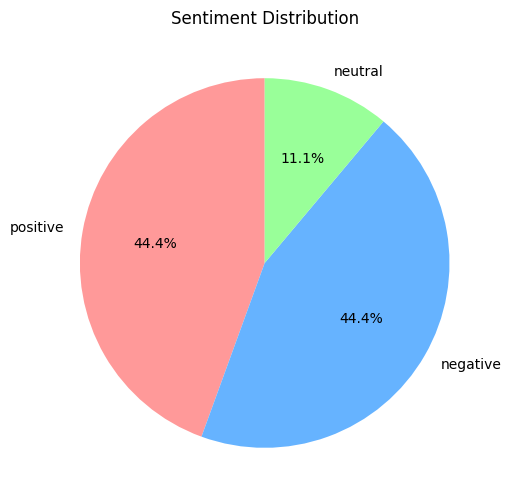

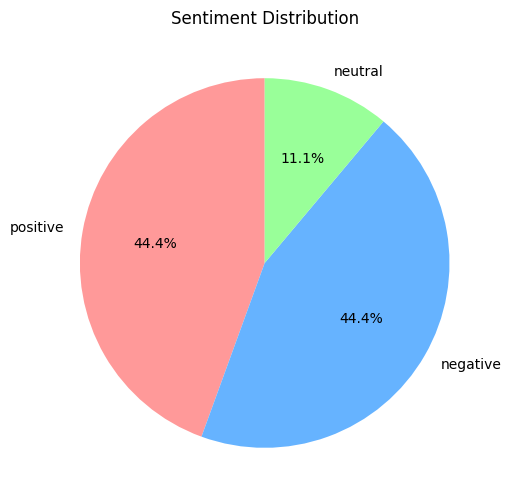

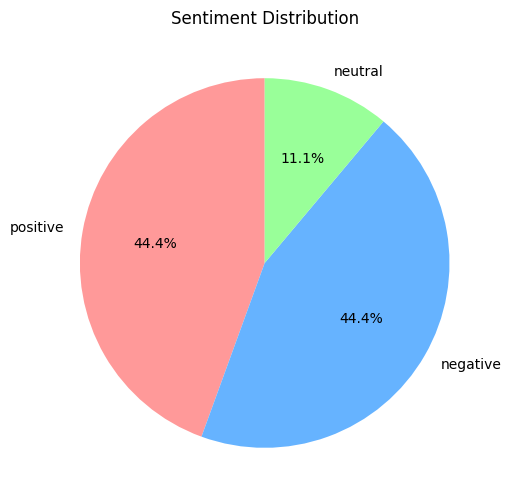

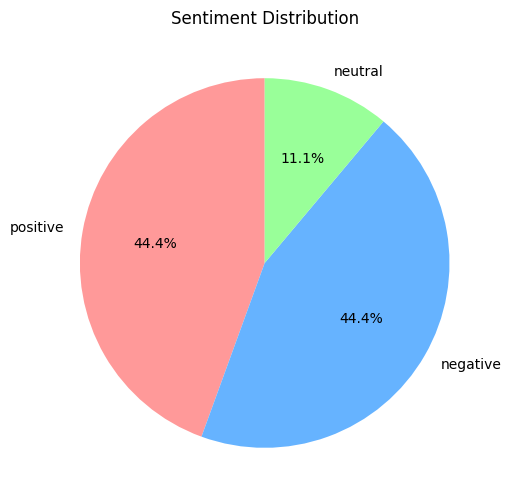

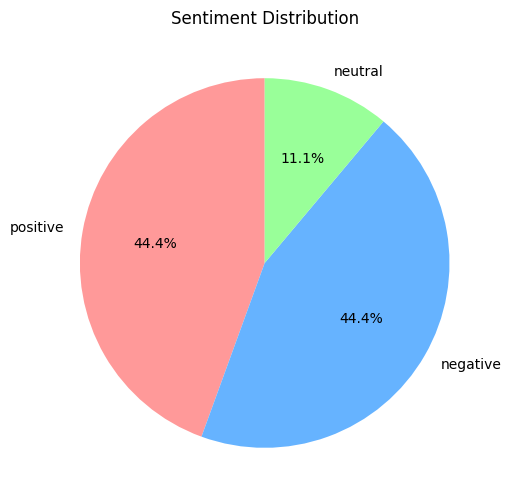

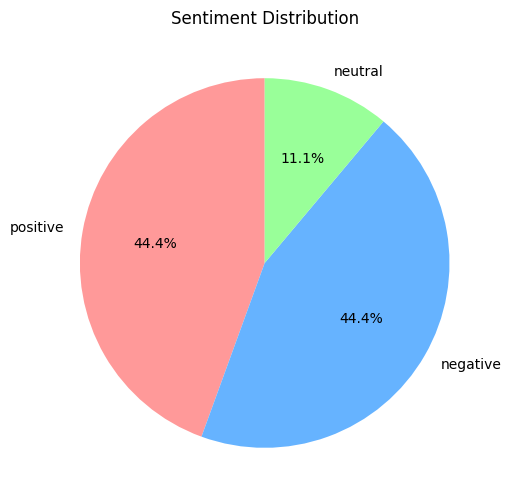

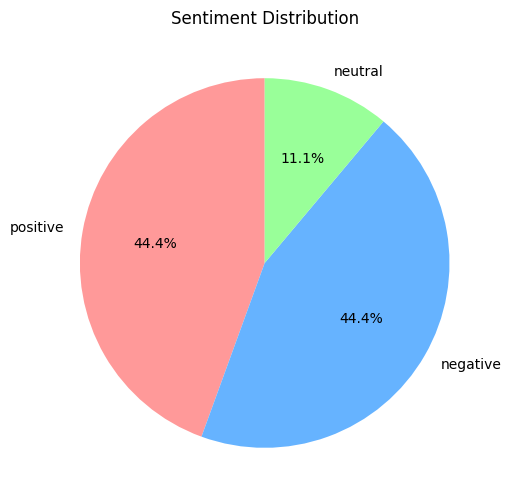

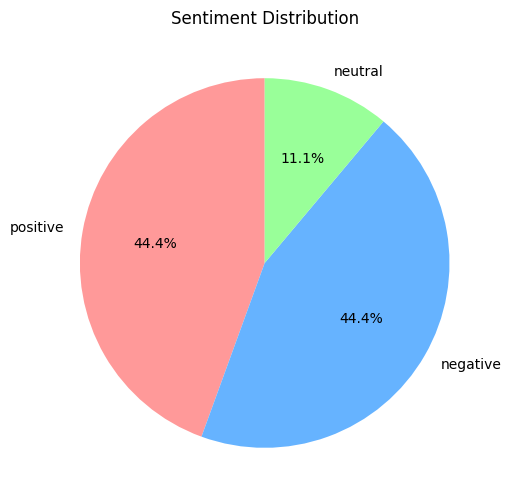

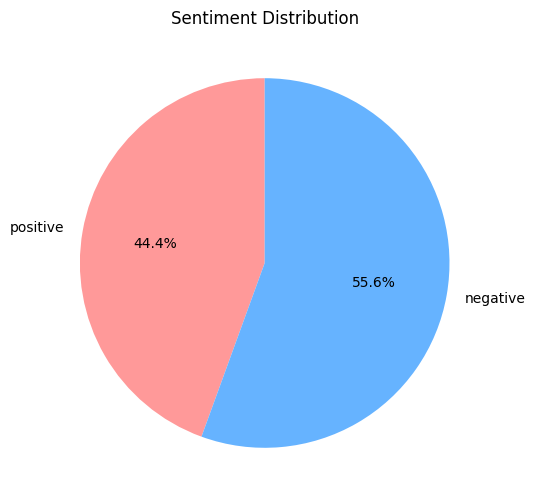

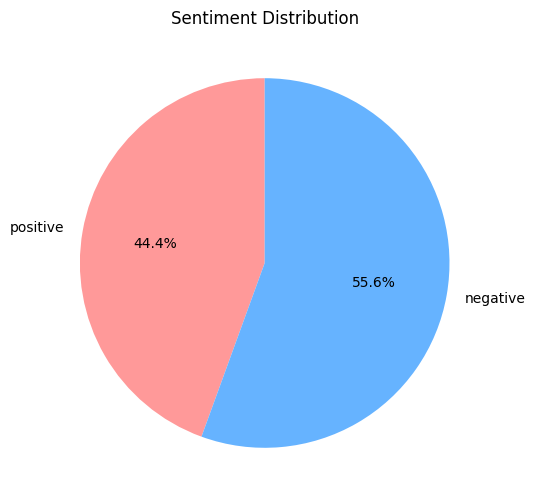

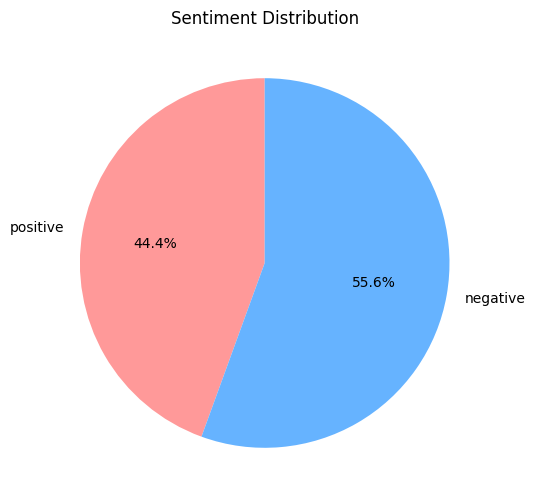

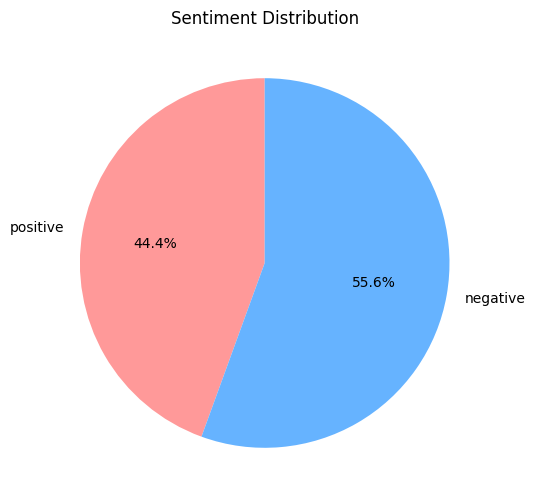

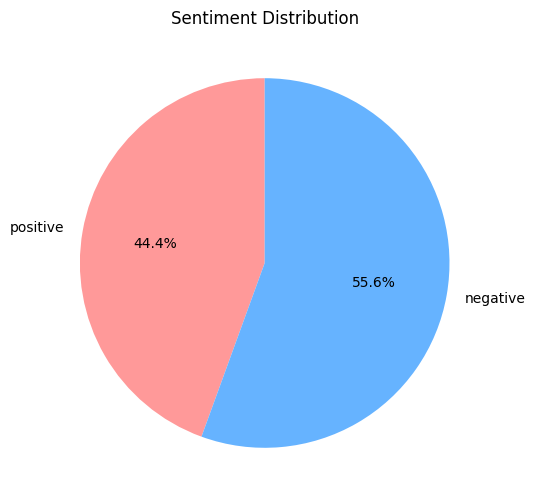

In [45]:
%matplotlib notebook
%matplotlib inline

# Count the number of sentences per sentiment
counts = Counter(predictions)
# Prepare data for pie chart
labels = counts.keys()
sizes = counts.values()
colors = ['#ff9999','#66b3ff','#99ff99']  # red, blue, green
# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Sentiment Distribution")
plt.show()